# Prophet model

## Učitavanje biblioteka

In [1]:
# Standardne biblioteke
import warnings 
import calendar
import pickle

# Obrada podataka
import pandas as pd
import numpy as np

# Modelovanje (Prophet)
from prophet import Prophet

# Vizualizacija
import matplotlib.pyplot as plt
import seaborn as sns

# Statističke i matematičke funkcije
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Machine learning modeli, metrika i evaluacija
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix

# Progres bar za petlje
from tqdm import tqdm

# Lokalni notebook za grafove
%run 00_graphs.ipynb

# Isključenje upozorenja
warnings.filterwarnings('ignore')

c:\Users\lukam\anaconda3\envs\op_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
c:\Users\lukam\anaconda3\envs\op_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Učitavanje podataka i pripremanje stukture za prophet

In [7]:
df = pd.read_csv('spatiotemporal_kriging_predictions.csv', parse_dates = ['date'])
location = 'POŽAREVAC'
allergen = 'AMBROZIJA'
data = df[(df.allergen == allergen) & (df.location == location)]
weather = pd.read_csv('meteo/meteo_df.csv', parse_dates=['date'])
data = pd.merge(left=data, right=weather, how='left', on=['date', 'location'])

data_prophet = data.rename(columns={'date': 'ds', 'value': 'y'})
data_prophet['y'] = np.log1p(data_prophet['y']/30)

## GRID search + Rolling Forecast

In [ ]:
def get_mixed_recent_and_seasonal_training_data(data, current_date, window=15, recent_days=30):
    """
    Vraća trening podatke iz sezonskog prozora ±window dana i poslednjih recent_days dana.
    """
    ref_doy = current_date.timetuple().tm_yday
    min_doy = ref_doy - window
    max_doy = ref_doy + window
    data = data.copy()
    data["doy"] = data["ds"].dt.dayofyear

    seasonal = data[(data["ds"] < current_date) & (data["doy"].between(min_doy, max_doy))]
    recent = data[(data["ds"] < current_date) & (data["ds"] >= current_date - pd.Timedelta(days=recent_days))]

    combined = pd.concat([seasonal, recent]).drop_duplicates().sort_values("ds")
    return combined.drop(columns="doy")


def rolling_prophet_forecast(data, start_date, end_date, horizon=15, regressors=None, holidays=None, changepoint_prior_scale=0.5, seasonality_prior_scale=10, seasonality_mode='additive', changepoint_range = 0.95, mod=1):
    """
    Rolling forecast evaluacija modela za dat opseg datuma.
    """
    results = []
    current_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    valid_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    for current_date in tqdm(valid_dates, desc="Rolling forecast"):
        # Kreiranje trening skupa prema izabranom modu
        if mod==0:
            train_data = data[data['ds'] < current_date].copy()
        else:
            #train_df = get_mixed_recent_and_seasonal_training_data(current_date, window=horizon + 10, recent_days=40)
            train_data = get_mixed_recent_and_seasonal_training_data(data, current_date, window=35)

        # Refit modela
        model = Prophet(
            holidays=holidays,
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=changepoint_prior_scale,
            changepoint_range=changepoint_range,
            seasonality_prior_scale=seasonality_prior_scale,
            seasonality_mode=seasonality_mode
        )
        model.add_seasonality(name='yearly_custom', period=365.25, fourier_order=10)
        for reg in regressors:
            model.add_regressor(reg)
        model.fit(train_data)

        # Generisanje future DataFrame-a za predikciju
        future = pd.date_range(start=current_date, periods=horizon)
        future_df = pd.DataFrame({"ds": future})

        for reg in regressors:
            future_df[reg] = data.set_index("ds").reindex(future)[reg].values

        future_df = future_df.dropna(subset=regressors)

        preds = np.zeros(horizon)
        lower_bounds = np.zeros(horizon)
        upper_bounds = np.zeros(horizon)

        if not future_df.empty:
            forecast = model.predict(future_df)

            forecast["yhat"] = 30 * np.expm1(forecast["yhat"])
            forecast["yhat_lower"] = 30 * np.expm1(forecast["yhat_lower"])
            forecast["yhat_upper"] = 30 * np.expm1(forecast["yhat_upper"])

            for _, rowf in forecast.iterrows():
                idx = (rowf["ds"] - current_date).days
                if 0 <= idx < horizon:
                    preds[idx] = np.round(np.clip(rowf["yhat"], 0, None))
                    lower_bounds[idx] = np.clip(rowf["yhat_lower"], 0, None)
                    upper_bounds[idx] = np.clip(rowf["yhat_upper"], 0, None)

        actuals = data[data["ds"].isin(future)]["y"].values
        actuals = 30 * np.expm1(actuals)
        actuals = np.pad(actuals, (0, max(horizon - len(actuals), 0)), constant_values=np.nan)

        result_row = {
            "date": current_date,
            "actual": actuals[0] if len(actuals) > 0 else np.nan,
            "prediction": preds[0] if len(preds) > 0 else np.nan
        }

        for i in range(horizon):
            result_row[f"pred{i}d"] = preds[i] if i < len(preds) else np.nan
            result_row[f"pred{i}d_lower"] = lower_bounds[i] if i < len(lower_bounds) else np.nan
            result_row[f"pred{i}d_upper"] = upper_bounds[i] if i < len(upper_bounds) else np.nan

        results.append(result_row)
        current_date += pd.Timedelta(days=1)

    return pd.DataFrame(results)


# Definisanje parametara za grid search
param_grid = {
    'changepoint_prior_scale': [0.1, 0.2, 0.5],
    'seasonality_prior_scale': [ 1.0, 2, 5.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.6, 0.8, 0.95],
}
grid = list(ParameterGrid(param_grid))

results = []
for params in tqdm(grid):
    # Rolling forecast sa trenutnom kombinacijom hiperparametara
    rolling_df = rolling_prophet_forecast(
    data=data_prophet,
    start_date='2024-08-01',
    end_date="2024-09-30",
    horizon=1,
    regressors=['temperature', 'humidity'],
    changepoint_prior_scale = params['changepoint_prior_scale'],
    seasonality_prior_scale = params['seasonality_prior_scale'], 
    seasonality_mode = params['seasonality_mode'],
    changepoint_range = params['changepoint_range']
    )

    true = rolling_df['actual'].values
    pred = rolling_df['prediction'].values

    mask = ~np.isnan(true) & ~np.isnan(pred)
    true = true[mask]
    pred = pred[mask]

    results.append({
        'params': params,
        'rmse' : np.sqrt(np.mean((true-pred)**2)),
        'mae' : np.mean(np.abs(true-pred)),
        'rmsle': np.sqrt(np.mean((np.log1p(true/30) - np.log1p(pred/30)) ** 2))
    })
    
results_df = pd.DataFrame(results)

# Prikaz najboljih rezultata
best_result = results_df.sort_values('rmse').iloc[0]

print("Najbolji parametri:", best_result['params'])
print("RMS log greška:", round(best_result['rmsle'], 4))
print("RMSE:", round(best_result['rmse'], 4))
print("MAE:", round(best_result['mae'], 4))

Najbolji parametri: {'changepoint_prior_scale': 0.2, 'changepoint_range': 0.95, 'mod': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2}
RMS log greška: 0.3927
RMSE: 73.2852
MAE: 40.5357


In [ ]:
rolling_df = rolling_prophet_forecast(
    data=data_prophet,
    start_date='2024-07-09', end_date="2024-09-30",
    horizon=30,
    regressors=['temperature', 'precipitation', 'humidity', 'wind'],
    changepoint_prior_scale= best_result['params']['changepoint_prior_scale'], 
    seasonality_prior_scale = best_result['params']['seasonality_prior_scale'], 
    seasonality_mode = best_result['params']['seasonality_mode'], 
    changepoint_range = best_result['params']['changepoint_range']
)

## Prikaz predikcije za sledeći dan

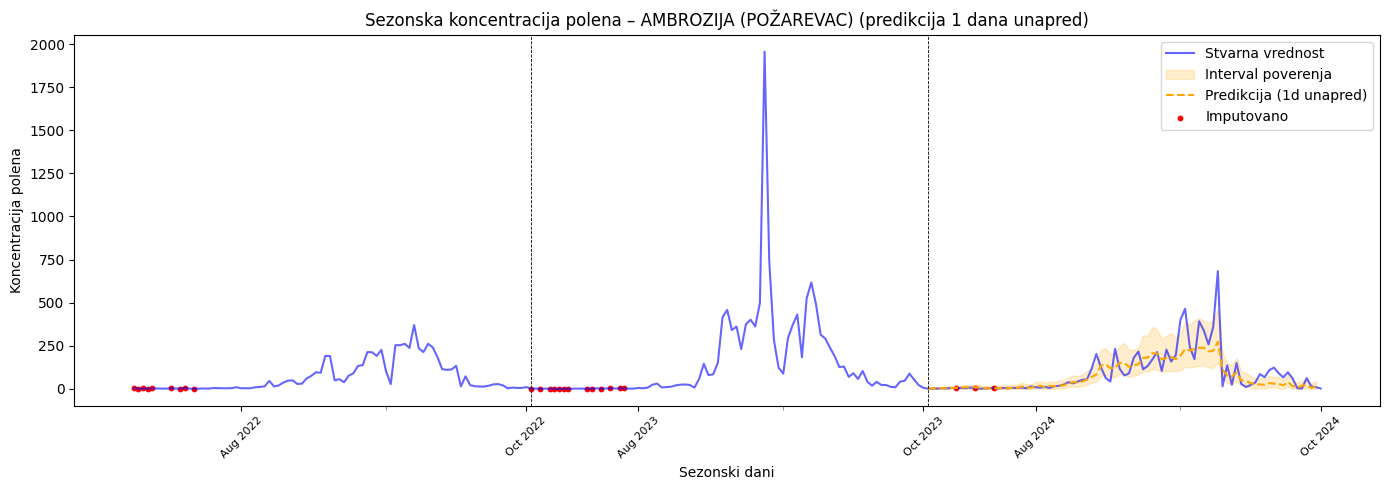

In [ ]:
plot_seasonal_predictions(data = data, 
                          forecast_df = rolling_df, 
                          allergen = allergen, 
                          location = location, 
                          n_seasons=3, 
                          n_days=1, 
                          col='value', 
                          save=False)

## Prikaz predikcije za 7. dan unapred

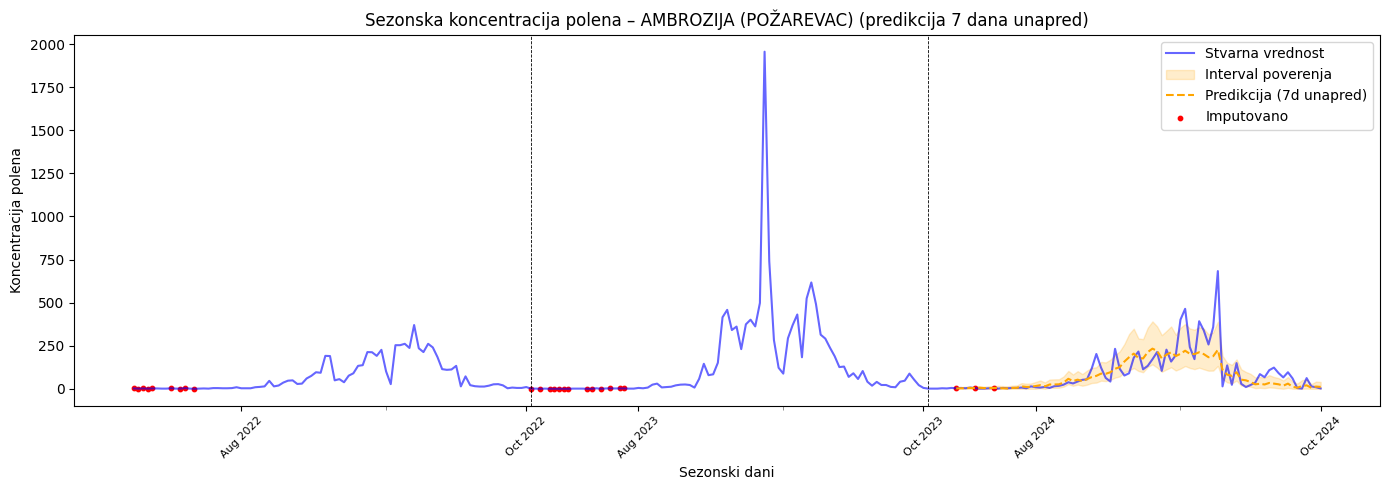

In [ ]:
plot_seasonal_predictions(data = data, 
                          forecast_df = rolling_df, 
                          allergen = allergen, 
                          location = location, 
                          n_seasons=3, 
                          n_days=7, 
                          col='value', 
                          save=True)

## Prikaz predikcije 30 dana unapred

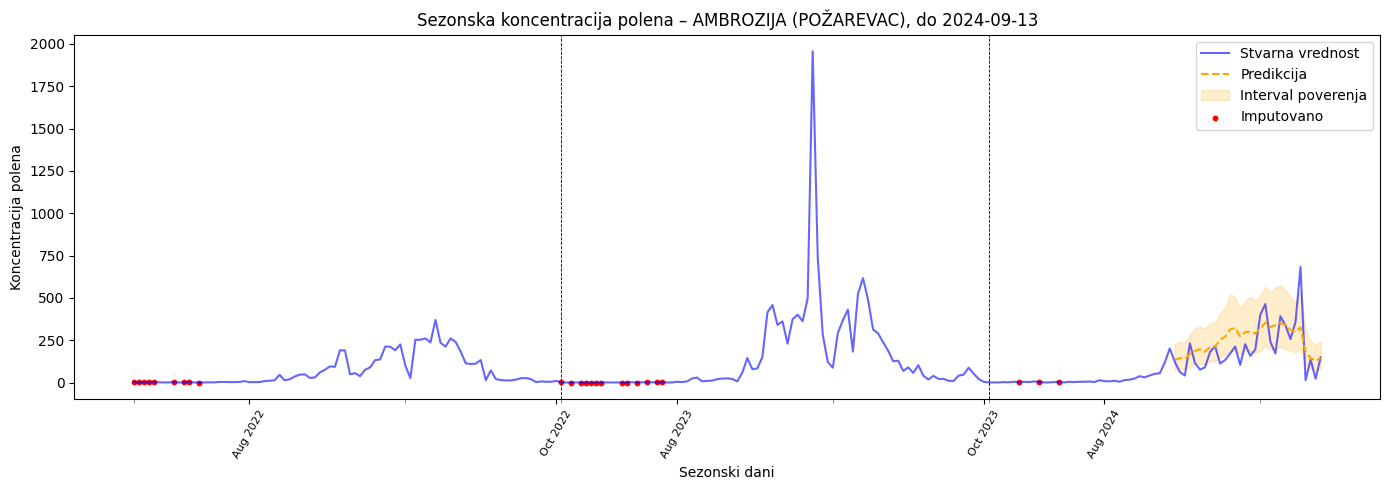

In [ ]:
plot_seasonal_predictions_limited(data = data, 
                                  forecast_df = rolling_df, 
                                  cutoff_date = '2024-08-15', 
                                  n_seasons=3, 
                                  col='value', 
                                  days_to_predict=30, 
                                  save=True)

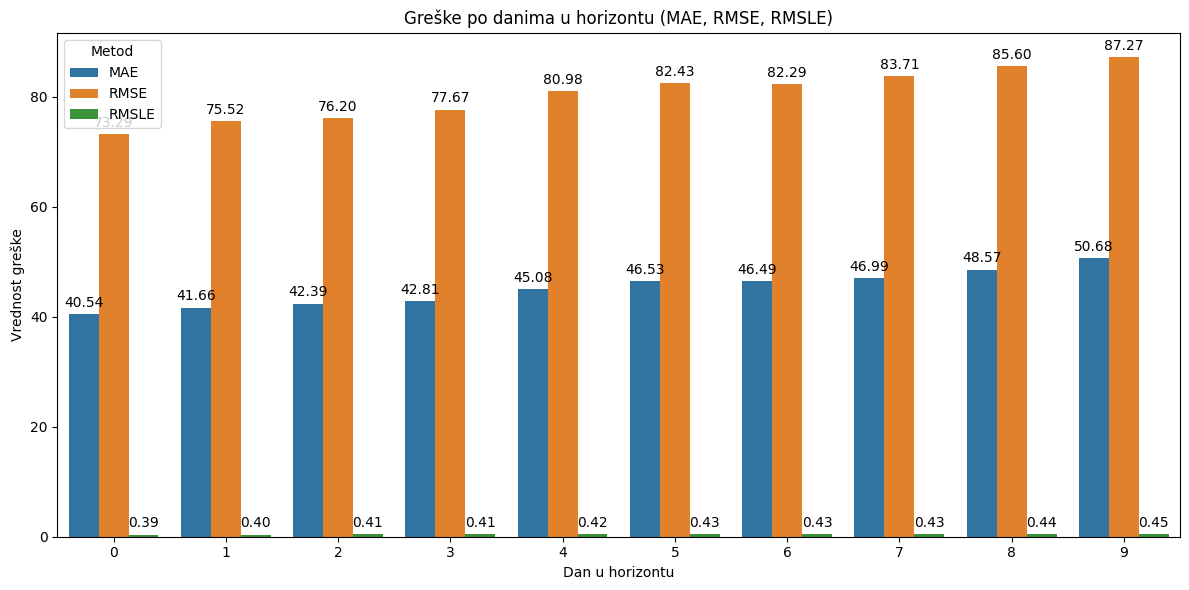

In [ ]:
plot_forecast_error_metrics_from_rolling(rolling_df = rolling_df, 
                                             allergen=allergen, 
                                             location=location, 
                                             horizon=10, 
                                             save=False)

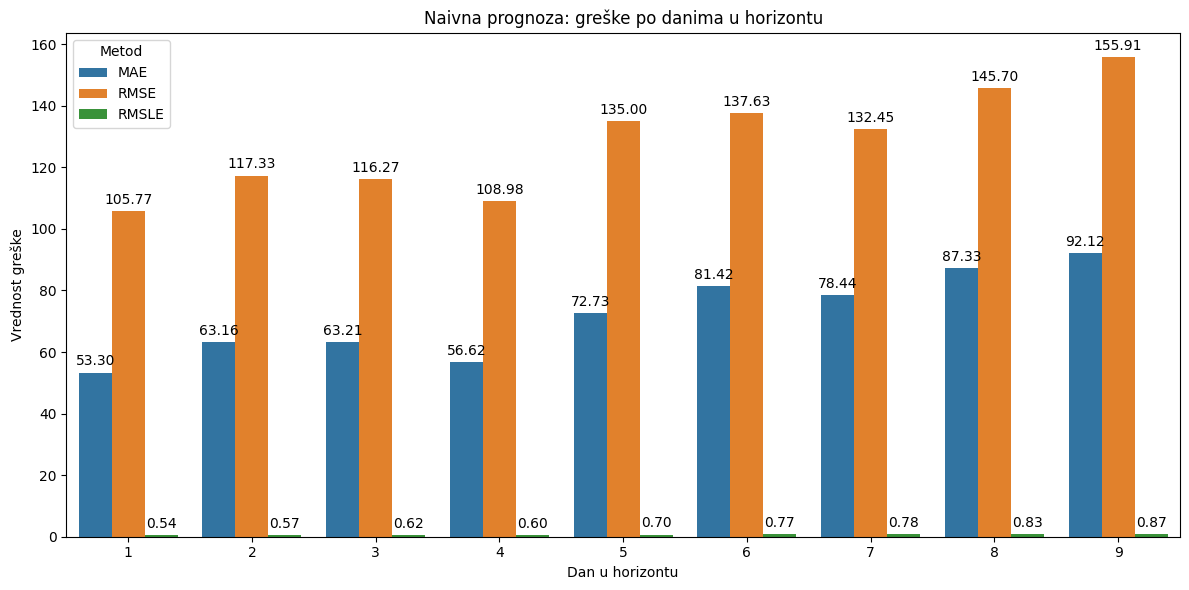

In [ ]:
plot_naive_forecast_metrics_from_rolling(rolling_df = rolling_df, 
                                         allergen=allergen, 
                                         location=location, 
                                         horizon=10, 
                                         save=False)


In [2]:
class ProphetPipeline:
    """
    ProphetPipeline klasa za predikciju vremenskih serija polena koristeći:
    - log ili Box-Cox transformaciju target promenljive,
    - Furijeove komponente za modelovanje sezonskih obrazaca,
    - Prophet model sa opcionim egzogenim varijablama (npr. meteorološki podaci).
    """
    def __init__(self, transform=None, exog_cols=None, value_col="value", date_col="date"):

        assert transform in ['log', 'boxcox', None], "Transformacija mora biti 'log', 'boxcox' ili None."
        self.transform = transform
        self.exog_cols = exog_cols if exog_cols is not None else []  # meteo promenljive
        self.value_col = value_col # naziv kolone za vrednost
        self.date_col = date_col # naziv vremenske kolone
        self.rolling_df = None # Evaluacija modela
        self.auto_res = None # Rezultati automatskog podešavanja
        self.fitted_model = None # Fitovani Prophet model
        self.rolling_dfs = None # Lista rezultata po transformaciji
        self.metrics_df = None # Objedinjene metrike performansi
        self.classification_results = None #Klasifikacija polena po nivoima
        
        
        # Inicijalni hyperparametri
        self.changepoint_prior_scale = 0.5 
        self.seasonality_prior_scale = 10
        self.seasonality_mode = 'additive'
        self.changepoint_range = 0.95
        self.mod = 1

    def _apply_transform(self, series):
        """
        Transformacija niz.
        """
        if self.transform == 'log':
            transformed = np.log1p(series/30)
            self.lmbda = None
        elif self.transform == 'boxcox':
            safe_val = series + 1e-1
            transformed, self.lmbda = boxcox(safe_val)
        else:  # None
            transformed = series
            self.lmbda = None
        return transformed

    def _inverse_transform(self, series):
        """
        Inverzna transformacija serije.
        """
        if self.transform == 'log':
            return 30 * np.expm1(series)
        elif self.transform == 'boxcox':
            return inv_boxcox(series, self.lmbda) - 1e-1
        return series

    def _get_md(self):
        """
        Detekcija početka i kraja sezone.
        """
        min_md = self.data[self.date_col].apply(lambda x: (x.month, x.day)).min()
        max_md = self.data[self.date_col].apply(lambda x: (x.month, x.day)).max()
        return min_md, max_md
    
    def _check_exog_cols(self, df):
        """
        Provera da li df sadrži sve exog kolone.
        """
        missing_cols = [col for col in self.exog_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Nedostaju egzogene kolone u df: {missing_cols}")

    def _get_valid_dates(self, start_date, end_date):
        """
        Pronalazi sve datume izmedju start_date i end_date koji su u sezoni.
        """
        all_dates = pd.date_range(start=start_date, end=end_date)
        valid_dates = [d for d in all_dates if self.start_md <= (d.month, d.day) < self.end_md]
        return valid_dates
    
    def _get_next_valid_dates(self, n_days):
        """
        Vraca sledećih n_days validnih datuma od poslednjeg definisanog datuma.
        """
        last_date = self.data[self.date_col].max()
        found = []
        candidate = last_date + pd.Timedelta(days=1)
        while len(found) < n_days:
            md = (candidate.month, candidate.day)
            if self.start_md <= md < self.end_md:
                found.append(candidate)
            candidate += pd.Timedelta(days=1)
        return found

    def _set_params(self, changepoint_prior_scale=None, seasonality_prior_scale=None, seasonality_mode=None, changepoint_range=None, mod = None):
        """
        Postavljanje hiperparametara Prophet modela.
        """
        if changepoint_prior_scale: self.changepoint_prior_scale = changepoint_prior_scale
        if seasonality_prior_scale: self.seasonality_prior_scale = seasonality_prior_scale
        if seasonality_mode: self.seasonality_mode = seasonality_mode
        if changepoint_range: self.changepoint_range = changepoint_range
        if mod: self.mod=mod

    def _get_mixed_recent_and_seasonal_training_data(self, current_date, window=35, recent_days=50):
        """
        Vraća trening podatke iz sezonskog prozora ±window dana i poslednjih recent_days dana.
        """
        
        ref_doy = current_date.timetuple().tm_yday
        min_doy = ref_doy - window
        max_doy = ref_doy + window
        data = self.data.copy()
        data["doy"] = data["ds"].dt.dayofyear

        seasonal = data[(data["ds"] < current_date) & (data["doy"].between(min_doy, max_doy))]
        recent = data[(data["ds"] < current_date) & (data["ds"] >= current_date - pd.Timedelta(days=recent_days))]

        combined = pd.concat([seasonal, recent]).drop_duplicates().sort_values("ds")
        return combined.drop(columns="doy")
    
    def _preprocess(self, df):
        """
        Predprocesiranje ulaznog DataFrame-a pre treniranja modela.
        """
        # Provera prisustva svih egzogenih kolona
        self._check_exog_cols(df)

        # Kreiranje kopije ulaznih podataka
        self.data = df.copy()

        # Dodavanje kolone 'ds'
        self.data['ds'] = self.data[self.date_col]

        # Transformacija target kolone i čuvanje u 'transform'
        self.data['y'] = self._apply_transform(self.data[self.value_col])

        # Detekcija početnog i krajnjeg meseca/dana u sezoni
        self.start_md, self.end_md = self._get_md()

    def fit(self, data, changepoint_prior_scale=None, seasonality_prior_scale=None, seasonality_mode=None, changepoint_range=None, preprocessed = False):
        """
        Fitovanje Prophet modela sa prosleđenim parametrima.
        """

        if not preprocessed:
            self._preprocess(data)
            self._set_params(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, seasonality_mode=seasonality_mode, changepoint_range=changepoint_range)

        # Inicijalizacija modela
        model = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=self.changepoint_prior_scale,
            changepoint_range=self.changepoint_range,
            seasonality_prior_scale=self.seasonality_prior_scale,
            seasonality_mode=self.seasonality_mode
        )
        model.add_seasonality(name='yearly_custom', period=365.25, fourier_order=10)
        if self.exog_cols:
            for reg in self.exog_cols:
                model.add_regressor(reg)

        if preprocessed:
            self.fitted_model = model.fit(data)
        else:
            self.fitted_model = model.fit(self.data)
        return self.fitted_model

    def forecast(self, days=1, exog_df=None):
        """
        Predviđa vrednosti za narednih `days` dana.
        """
        # Generisanje sledećih validnih datuma za predikciju
        forecast_dates = self._get_next_valid_dates(n_days=days)
        future_df = pd.DataFrame({'ds': forecast_dates})

        # Ako postoje egzogene promenljive, priprema future_df sa njima
        if self.exog_cols:
            if exog_df is None:
                raise ValueError("exog_df mora biti prosleđen jer su exog_cols definisane.")
            self._check_exog_cols(exog_df)

            exog_df = exog_df.copy()
            exog_df['ds'] = pd.to_datetime(exog_df[self.date_col])
            exog_df = exog_df.set_index('ds')
            exog_df = exog_df[self.exog_cols].reset_index()

            future_df = future_df.merge(exog_df, on='ds', how='left')

        # Predikcija korišćenjem treniranog Prophet modela
        forecast = self.fitted_model.predict(future_df)
        preds_orig = self._inverse_transform(forecast['yhat'])
        return pd.Series(preds_orig, index=forecast_dates, name='prediction')

    def grid_search(self, data, param_grid, start_date, end_date, transforms=0):
        """
        Grid search za optimizaciju Prophet hiperparametara koristeći rolling forecast.
        """
        if transforms == 0:
                transforms = [self.transform] 

        grid = list(ParameterGrid(param_grid))
        self.auto_res = {}        

        best_all = []  # lista najboljih za sve transformacije

        for transform in tqdm(transforms, desc="Transformations"):
            
            # Predprocesiranje ulaznih podataka
            self.transform = transform
            self._preprocess(data)

            results = []

            # Iteracija kroz sve kombinacije hiperparametara
            for params in tqdm(grid, desc=f"Grid for {transform}", leave=False):

                self._set_params(
                    changepoint_prior_scale=params.get('changepoint_prior_scale', None),
                    seasonality_prior_scale=params.get('seasonality_prior_scale', None),
                    seasonality_mode=params.get('seasonality_mode', None),
                    changepoint_range=params.get('changepoint_range', None),
                    mod = params.get('mod', None),
                )

                # Rolling forecast evaluacija za trenutni set parametara
                rolling_df = self.rolling_forecast(start_date=start_date, end_date=end_date, horizon=1)
                true = rolling_df['actual'].values
                pred = rolling_df['prediction'].values

                mask = ~np.isnan(true) & ~np.isnan(pred)
                true = true[mask]
                pred = pred[mask]

                # Računanje metrika i čuvanje rezultata
                results.append({
                    'transform': transform,
                    'params': params,
                    'rmse': np.sqrt(np.mean((true - pred) ** 2)),
                    'mae': np.mean(np.abs(true - pred)),
                    'rmsle': np.sqrt(np.mean((np.log1p(true / 30) - np.log1p(pred / 30)) ** 2))
                })

            # Izbor najboljeg po modela
            results_df = pd.DataFrame(results)
            self.auto_res[transform] = results_df

            if not results_df.empty:
                best_result = results_df.sort_values('rmsle').iloc[0]
                best_all.append(best_result)

        # Najbolji hiperparametar svih transformacija
        if best_all:
            best_overall = pd.DataFrame(best_all).sort_values("rmsle").iloc[0]

            self.transform = best_overall['transform']
            self._set_params(**best_overall['params'])

        return self.auto_res
    
    def evaluate_model(self, start_date, end_date, horizon=30, low=30, high=100):
        """
        Evaluacija najboljih Prophet modela po transformaciji.
        Radi rolling forecast, računa regresione i klasifikacione metrike.
        """

        if not isinstance(self.auto_res, dict) or not self.auto_res:
            raise ValueError("auto_res mora biti dict sa rezultatima po transformaciji. Pokreni grid_search() pre evaluate_model().")

        data = self.data.copy()

        self.rolling_dfs = {}       
        self.metrics_dfs = {}      
        classification_results = {}

        for transform, results_df in self.auto_res.items():
            if results_df.empty:
                continue

            best_row = results_df.sort_values('rmsle').iloc[0]

            self.transform = transform
            self._set_params(**dict(best_row['params']))
            self._preprocess(data)

            rolling_df = self.rolling_forecast(start_date, end_date, horizon=horizon)
            self.rolling_dfs[transform] = rolling_df

            all_metrics = []
            transform_class_results = {}

            for i in range(horizon):
                col_pred = f"pred{i}d"
                col_actual = f"actual{i}d"
                rolling_df[col_actual] = rolling_df["actual"].shift(-i)

                actual = rolling_df[col_actual]
                pred = rolling_df[col_pred]
                mask = actual.notna() & pred.notna()

                if mask.sum() == 0:
                    continue

                # Regresione metrike
                all_metrics.append({
                    "transform": transform,
                    "forecast_day": i,
                    "MAE": np.mean(np.abs(pred[mask] - actual[mask])),
                    "RMSE": np.sqrt(np.mean((pred[mask] - actual[mask]) ** 2)),
                    "RMSLE": np.sqrt(np.mean((np.log1p(pred[mask] / 30) - np.log1p(actual[mask] / 30)) ** 2))
                })

                # Klasifikacija
                def classify(x):
                    if x < low:
                        return 'low'
                    elif x < high:
                        return 'moderate'
                    else:
                        return 'high'

                actual_cls = actual[mask].apply(classify)
                pred_cls = pred[mask].apply(classify)

                labels = ['low', 'moderate', 'high']
                cm = confusion_matrix(actual_cls, pred_cls, labels=labels)
                report = classification_report(actual_cls, pred_cls, labels=labels, output_dict=True)

                transform_class_results[i] = {
                    "confusion_matrix": cm,
                    "classification_report": report
                }

            self.metrics_dfs[transform] = pd.DataFrame(all_metrics)
            classification_results[transform] = transform_class_results

        self.classification_results = classification_results

        return self.metrics_dfs, self.rolling_dfs

    def rolling_forecast(self, start_date, end_date, horizon=30):
        """
        Rolling forecast evaluacija modela za dat opseg datuma.
        """
        results = []
        data = self.data.copy()
        valid_dates = self._get_valid_dates(start_date, end_date)

        for current_date in tqdm(valid_dates):
            # Kreiranje trening skupa prema izabranom modu
            if self.mod==0:
                train_df = data[data['ds'] < current_date].copy()
            else:
                train_df = self._get_mixed_recent_and_seasonal_training_data(current_date)
            # Refit modela
            self.fit(train_df, preprocessed=True)

            # Generisanje future DataFrame-a za predikciju
            future = pd.date_range(start=current_date, periods=horizon)
            future_df = pd.DataFrame({"ds": future})
            for reg in self.exog_cols:
                future_df[reg] = data.set_index("ds").reindex(future)[reg].values
            future_df = future_df.dropna(subset=self.exog_cols)

            preds = np.zeros(horizon)
            lower_bounds = np.zeros(horizon)
            upper_bounds = np.zeros(horizon)

            if not future_df.empty:
                forecast = self.fitted_model.predict(future_df)
                forecast['yhat'] = self._inverse_transform(forecast['yhat'])
                forecast['yhat_lower'] = self._inverse_transform(forecast['yhat_lower'])
                forecast['yhat_upper'] = self._inverse_transform(forecast['yhat_upper'])

                for _, rowf in forecast.iterrows():
                    idx = (rowf['ds'] - current_date).days
                    if 0 <= idx < horizon:
                        preds[idx] = np.round(np.clip(rowf['yhat'], 0, None))
                        lower_bounds[idx] = np.clip(rowf['yhat_lower'], 0, None)
                        upper_bounds[idx] = np.clip(rowf['yhat_upper'], 0, None)

            actual = data.loc[data[self.date_col] == current_date, self.value_col]
            actual = actual.iloc[0] if not actual.empty else np.nan

            result_row = {
                "date": current_date,
                "actual": actual,
                "prediction": preds[0] if len(preds) > 0 else np.nan
            }

            for i in range(horizon):
                result_row[f"pred{i}d"] = preds[i] if i < len(preds) else np.nan
                result_row[f"pred{i}d_lower"] = lower_bounds[i] if i < len(lower_bounds) else np.nan
                result_row[f"pred{i}d_upper"] = upper_bounds[i] if i < len(upper_bounds) else np.nan

            results.append(result_row)

        self.rolling_df = pd.DataFrame(results)
        return self.rolling_df

# Poredjenje više Prophet modela

## Najbolji modeli sa i bez meteo podataka, za boxcox, log i bez transoformacije

In [15]:
allergen = 'AMBROZIJA'
location = 'POŽAREVAC'

model_path = f"models/Prophet/{allergen}_{location}.pkl"
with open(model_path, 'rb') as f:
    loaded_model_meteo = pickle.load(f)

model_path = f"models/Prophet/{allergen}_{location}_nometeo.pkl"
with open(model_path, 'rb') as f:
    loaded_model_nometeo = pickle.load(f)

In [16]:
print("Najbolji modeli sa meteo kovarijatama (po RMSLE)")
best_meteo = []
for transform, df in loaded_model_meteo.auto_res.items():
    best_row = df.loc[df["rmsle"].idxmin()]
    best_row["transform"] = transform
    best_meteo.append(best_row)

best_meteo_df = pd.DataFrame(best_meteo)
print(best_meteo_df.to_string(index=False))

print("\nNajbolji modeli bez meteo kovarijata (po RMSLE)")
best_nometeo = []
for transform, df in loaded_model_nometeo.auto_res.items():
    best_row = df.loc[df["rmsle"].idxmin()]
    best_row["transform"] = transform
    best_nometeo.append(best_row)

best_nometeo_df = pd.DataFrame(best_nometeo)
print(best_nometeo_df.to_string(index=False))


Najbolji modeli sa meteo kovarijatama (po RMSLE)
transform                                                                                                                                     params       rmse       mae    rmsle
     None {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.6, 'mod': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.0} 199.981457 78.559524 0.464033
   boxcox   {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.6, 'mod': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2} 191.394444 67.428571 0.399975
      log {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'mod': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} 179.401386 70.333333 0.399584

Najbolji modeli bez meteo kovarijata (po RMSLE)
transform                                                                                                                                     params       rmse       mae    rmsle
     No

In [40]:
print("\nNajbolji modeli SA meteo (po RMSLE)")

print("Log:")
print(
    loaded_model_meteo.metrics_dfs['log']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)

print("BoxCox:")
print(
    loaded_model_meteo.metrics_dfs['boxcox']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)

print("None:")
print(
    loaded_model_meteo.metrics_dfs[None]
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)


print("\nNajbolji modeli BEZ meteo (po RMSLE)")

print("Log:")
print(
    loaded_model_nometeo.metrics_dfs['log']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)

print("BoxCox:")
print(
    loaded_model_nometeo.metrics_dfs['boxcox']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)

print("None:")
print(
    loaded_model_nometeo.metrics_dfs[None]
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)



Najbolji modeli SA meteo (po RMSLE)
Log:
   RMSLE      RMSE       MAE
0.461794 85.064471 51.059524
BoxCox:
   RMSLE      RMSE       MAE
0.413303 66.979563 42.595238
None:
   RMSLE      RMSE       MAE
0.629803 105.22442 71.845238

Najbolji modeli BEZ meteo (po RMSLE)
Log:
  RMSLE      RMSE       MAE
0.50092 91.601037 54.369048
BoxCox:
   RMSLE      RMSE       MAE
0.458913 80.154464 44.952381
None:
   RMSLE       RMSE       MAE
0.573359 100.775918 64.666667


## RMSLE za naredih 7 dana

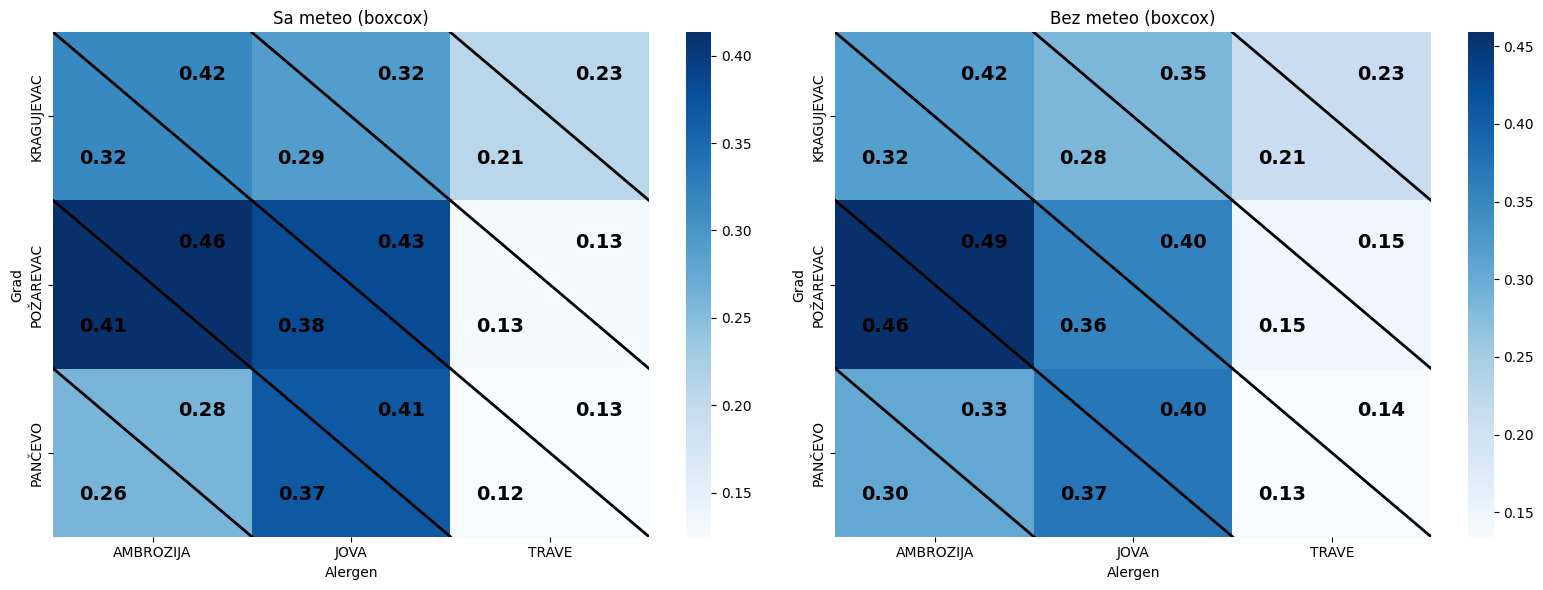

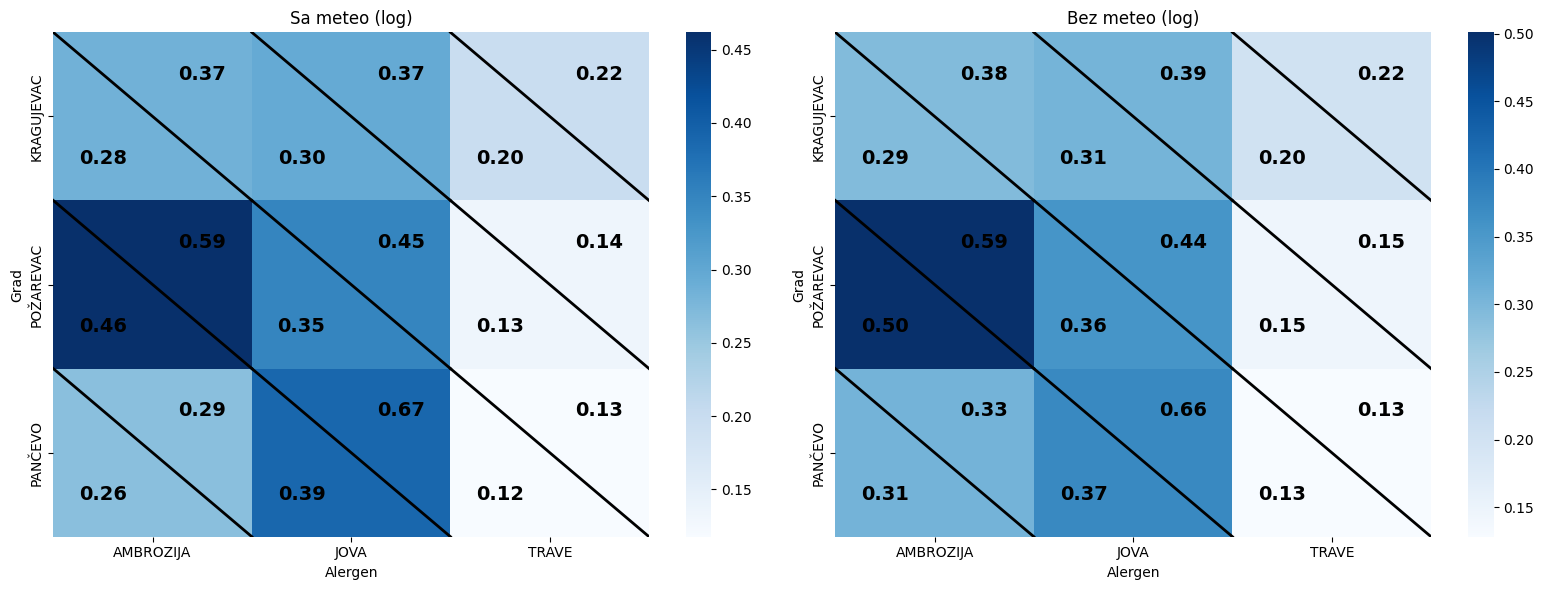

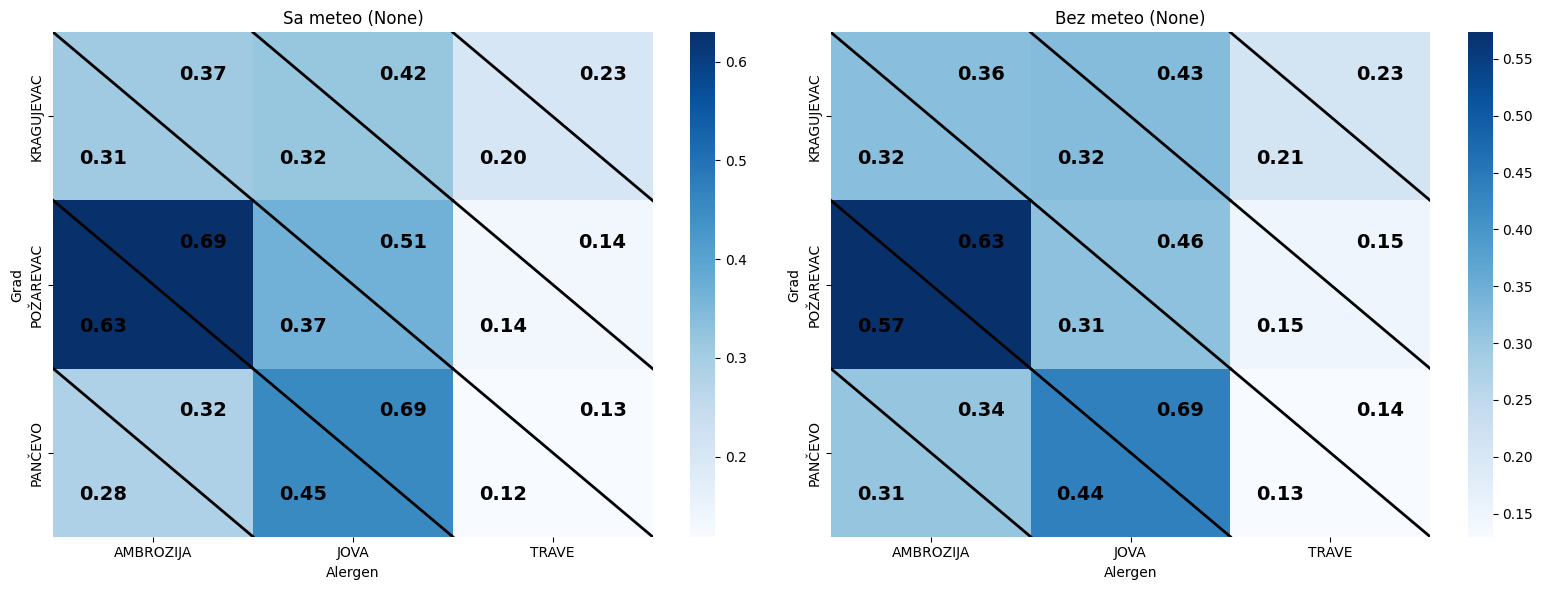

In [41]:
locations = ["KRAGUJEVAC", "POŽAREVAC", "PANČEVO"]
allergens = ["AMBROZIJA", "JOVA", "TRAVE"]

# Funkcija za kreiranje RMSLE DataFrame-a za zadatu transformaciju
def get_rmsle_df_transform(transform_type='log', with_meteo=True):
    rmsle_df_list = []
    for location in locations:
        for allergen in allergens:
            if with_meteo:
                model_path = f"models/Prophet/{allergen}_{location}.pkl"
            else:
                model_path = f"models/Prophet/{allergen}_{location}_nometeo.pkl"
            with open(model_path, 'rb') as f:
                loaded_model = pickle.load(f)
            
            if transform_type:
                metrics_df = loaded_model.metrics_dfs[transform_type.lower()]
            else:
                metrics_df = loaded_model.metrics_dfs[None]
            
            rmsle_day_0 = metrics_df[metrics_df['forecast_day'] == 0]['RMSLE'].values[0]
            rmsle_day_6 = metrics_df[metrics_df['forecast_day'] == 6]['RMSLE'].values[0]
            
            rmsle_df_list.append([location, allergen, rmsle_day_0, rmsle_day_6])
    
    return pd.DataFrame(rmsle_df_list, columns=['Grad', 'Alergen', 'RMSLE_Day_0', 'RMSLE_Day_6'])

# Kreiranje DataFrame-ova za obe transformacije i sa/bez meteo
rmsle_df_log_meteo = get_rmsle_df_transform('log', with_meteo=True)
rmsle_df_log_nometeo = get_rmsle_df_transform('log', with_meteo=False)

rmsle_df_bc_meteo = get_rmsle_df_transform('boxcox', with_meteo=True)
rmsle_df_bc_nometeo = get_rmsle_df_transform('boxcox', with_meteo=False)

rmsle_df_none_meteo = get_rmsle_df_transform(None, with_meteo=True)
rmsle_df_none_nometeo = get_rmsle_df_transform(None, with_meteo=False)

def plot_heatmap_two_subplots(rmsle_meteo, rmsle_nometeo, title):
    pivot_meteo = rmsle_meteo.pivot(index="Grad", columns="Alergen", values="RMSLE_Day_0").reindex(locations)
    pivot_nometeo = rmsle_nometeo.pivot(index="Grad", columns="Alergen", values="RMSLE_Day_0").reindex(locations)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Heatmap sa meteo
    sns.heatmap(pivot_meteo, annot=False, cmap="Blues", ax=axes[0])
    axes[0].set_title(f"Sa meteo ({title})")
    for i, row in enumerate(rmsle_meteo.itertuples()):
        row_idx = locations.index(row.Grad)
        col_idx = allergens.index(row.Alergen)
        x, y = col_idx + 0.5, row_idx + 0.5
        axes[0].plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='black', lw=2)
        axes[0].text(x - 0.25, y + 0.25, f"{row.RMSLE_Day_0:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')
        axes[0].text(x + 0.25, y - 0.25, f"{row.RMSLE_Day_6:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')

    # Heatmap bez meteo
    sns.heatmap(pivot_nometeo, annot=False, cmap="Blues", ax=axes[1])
    axes[1].set_title(f"Bez meteo ({title})")
    for i, row in enumerate(rmsle_nometeo.itertuples()):
        row_idx = locations.index(row.Grad)
        col_idx = allergens.index(row.Alergen)
        x, y = col_idx + 0.5, row_idx + 0.5
        axes[1].plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='black', lw=2)
        axes[1].text(x - 0.25, y + 0.25, f"{row.RMSLE_Day_0:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')
        axes[1].text(x + 0.25, y - 0.25, f"{row.RMSLE_Day_6:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')

    plt.tight_layout()

plot_heatmap_two_subplots(rmsle_df_bc_meteo, rmsle_df_bc_nometeo, "boxcox")

plot_heatmap_two_subplots(rmsle_df_log_meteo, rmsle_df_log_nometeo, "log")

plot_heatmap_two_subplots(rmsle_df_none_meteo, rmsle_df_none_nometeo, None)


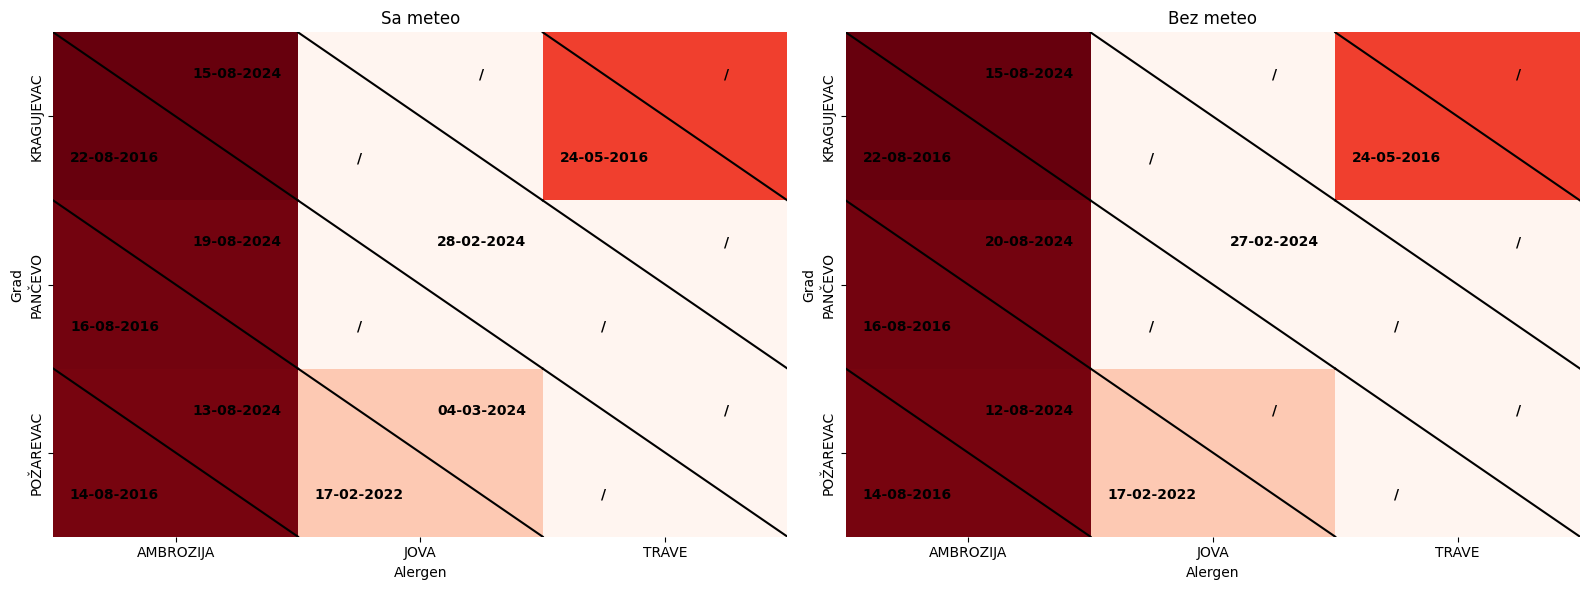

In [66]:
locations = ["KRAGUJEVAC", "POŽAREVAC", "PANČEVO"]
allergens = ["AMBROZIJA", "JOVA", "TRAVE"]

thresholds = {
    'AMBROZIJA': 30,
    'JOVA': 60,
    'TRAVE': 60
}

def first_3days_above_threshold(df, allergen, value_col='value', add_days=0):
    df = df.copy()
    threshold = thresholds[allergen]
    df['above_threshold'] = df[value_col] > threshold
    df['three_days'] = df['above_threshold'].rolling(3).sum() == 3
    if df['three_days'].any():
        first_idx = df[df['three_days']].index[0]
        first_date = df.loc[first_idx - 2, 'date']
        return first_date + pd.Timedelta(days=add_days)
    else:
        return pd.NaT
    
def first_3days_above_threshold_pred(df, allergen, add_days=7):
    threshold = thresholds[allergen]
    value_cols = [f'pred{add_days-1}d', f'pred{add_days}d', f'pred{add_days+1}d']
    df['above_threshold'] = df[value_cols].gt(threshold).all(axis=1)
    if df['above_threshold'].any(): 
        first_idx = df[df['above_threshold']].index[0]
        first_date = df.loc[first_idx, 'date']
        return first_date + pd.Timedelta(days=add_days) 
    else:
        return pd.NaT 

def create_concentration_dates_df(loaded_models, forecast_days=7, with_meteo=True):
    results_list = []
    for location in locations:
        for allergen in allergens:
            key = f"{allergen}_{location}" + ("" if with_meteo else "_nometeo")
            model = loaded_models[key]

            # Stvarna vrednost
            actual_date = first_3days_above_threshold(model.data, allergen, value_col='value', add_days=0)

            # Predikcija forecast_days ranije
            pred_date = first_3days_above_threshold_pred(
                model.rolling_dfs['log'],  # moze i 'boxcox'
                allergen,
                add_days=forecast_days
            )

            results_list.append({
                'Grad': location,
                'Alergen': allergen,
                'Stvarno': actual_date,
                'Predikcija_7d': pred_date + pd.Timedelta(days=6)
            })

    df = pd.DataFrame(results_list)
    df['Stvarno_formatted'] = df['Stvarno'].dt.strftime('%d-%m-%Y')
    df['Predikcija_7d_formatted'] = df['Predikcija_7d'].dt.strftime('%d-%m-%Y')
    return df

def plot_concentration_heatmap_subplots(df_meteo, df_nometeo, title="Ambrozija i Jova"):
    pivot_actual_meteo = df_meteo.pivot(index='Grad', columns='Alergen', values='Stvarno_formatted').fillna("/")
    pivot_pred_meteo = df_meteo.pivot(index='Grad', columns='Alergen', values='Predikcija_7d_formatted').fillna("/")

    pivot_actual_nometeo = df_nometeo.pivot(index='Grad', columns='Alergen', values='Stvarno_formatted').fillna("/")
    pivot_pred_nometeo = df_nometeo.pivot(index='Grad', columns='Alergen', values='Predikcija_7d_formatted').fillna("/")

    fig, axes = plt.subplots(1, 2, figsize=(16,6))

    # Funkcija za crtanje pojedinačnog heatmap-a sa dijagonalom
    def draw_diagonal_heatmap(ax, pivot_actual, pivot_pred, title_sub):
        color_matrix = pivot_actual.applymap(lambda x: pd.to_datetime(x).dayofyear if x != "/" else 0)
        sns.heatmap(color_matrix, annot=False, cmap="Reds", cbar=False, ax=ax)

        for i, grad in enumerate(pivot_actual.index):
            for j, allergen in enumerate(pivot_actual.columns):
                x, y = j + 0.5, i + 0.5
                ax.plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='black', lw=1.5)
                ax.text(x - 0.25, y + 0.25, pivot_actual.loc[grad, allergen],
                        ha='center', va='center', fontsize=10, color='black', fontweight='bold')
                ax.text(x + 0.25, y - 0.25, pivot_pred.loc[grad, allergen],
                        ha='center', va='center', fontsize=10, color='black', fontweight='bold')

        ax.set_title(title_sub)
        ax.set_ylabel("Grad")
        ax.set_xlabel("Alergen")

    draw_diagonal_heatmap(axes[0], pivot_actual_meteo, pivot_pred_meteo, "Sa meteo")

    draw_diagonal_heatmap(axes[1], pivot_actual_nometeo, pivot_pred_nometeo, "Bez meteo")

    plt.tight_layout()
    plt.show()

# Učitavanje modela 
loaded_models = {}
for location in locations:
    for allergen in allergens:
        # Sa meteo
        path_meteo = f"models/Prophet/{allergen}_{location}.pkl"
        with open(path_meteo, 'rb') as f:
            loaded_models[f"{allergen}_{location}"] = pickle.load(f)

        # Bez meteo
        path_nometeo = f"models/Prophet/{allergen}_{location}_nometeo.pkl"
        with open(path_nometeo, 'rb') as f:
            loaded_models[f"{allergen}_{location}_nometeo"] = pickle.load(f)

df_dates_meteo = create_concentration_dates_df(loaded_models, forecast_days=7, with_meteo=True)
df_dates_nometeo = create_concentration_dates_df(loaded_models, forecast_days=7, with_meteo=False)

plot_concentration_heatmap_subplots(df_dates_meteo, df_dates_nometeo)

## Rezultati klasifikacije za narednih 7 dana

In [67]:
allergen = 'AMBROZIJA'
location = 'POŽAREVAC'

model_path = f"models/Prophet/{allergen}_{location}.pkl"
with open(model_path, 'rb') as f:
    loaded_model_meteo = pickle.load(f)

model_path = f"models/Prophet/{allergen}_{location}_nometeo.pkl"
with open(model_path, 'rb') as f:
    loaded_model_nometeo = pickle.load(f)

loaded_model_nometeo.classification_results['boxcox'][6]

{'confusion_matrix': array([[28,  2,  3],
        [ 5,  8,  4],
        [ 1,  4, 23]]),
 'classification_report': {'low': {'precision': 0.8235294117647058,
   'recall': 0.8484848484848485,
   'f1-score': 0.8358208955223881,
   'support': 33},
  'moderate': {'precision': 0.5714285714285714,
   'recall': 0.47058823529411764,
   'f1-score': 0.5161290322580646,
   'support': 17},
  'high': {'precision': 0.7666666666666667,
   'recall': 0.8214285714285714,
   'f1-score': 0.793103448275862,
   'support': 28},
  'accuracy': 0.7564102564102564,
  'macro avg': {'precision': 0.7205415499533147,
   'recall': 0.7135005517358458,
   'f1-score': 0.7150177920187716,
   'support': 78},
  'weighted avg': {'precision': 0.7481720893485599,
   'recall': 0.7564102564102564,
   'f1-score': 0.7508099955429492,
   'support': 78}}}

## RMSLE vrednosti po različitim horizontima predikcije

In [62]:
allergen = 'AMBROZIJA'
location = 'POŽAREVAC'

model_path = f"models/Prophet/{allergen}_{location}.pkl"
with open(model_path, 'rb') as f:
    loaded_model_meteo = pickle.load(f)

model_path = f"models/Prophet/{allergen}_{location}_nometeo.pkl"
with open(model_path, 'rb') as f:
    loaded_model_nometeo = pickle.load(f)

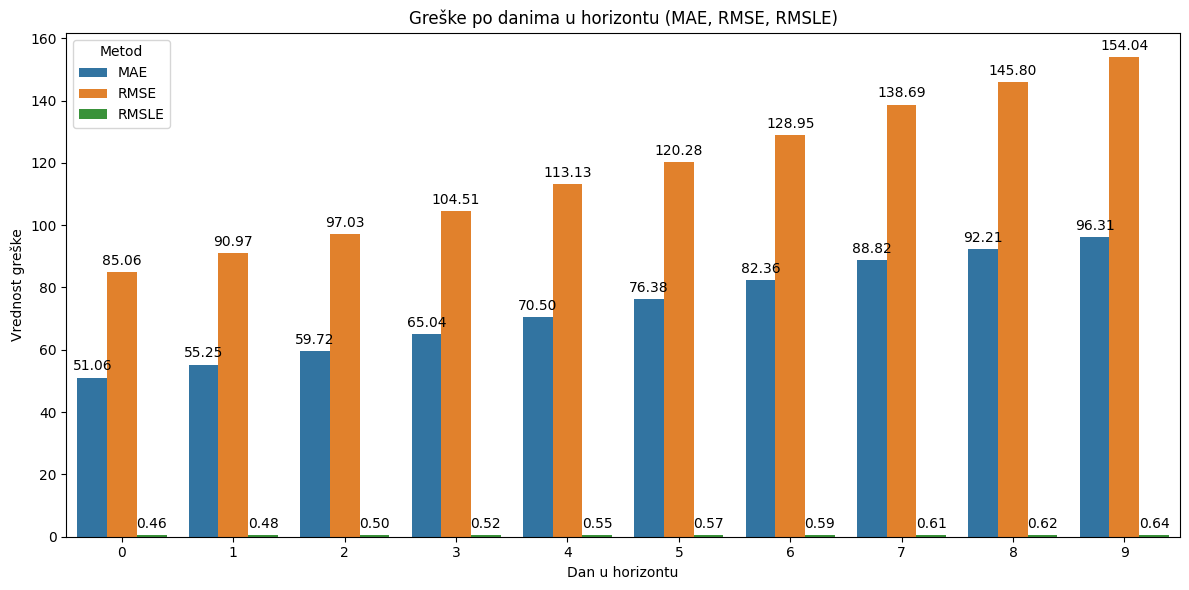

In [63]:
plot_forecast_error_metrics_from_rolling(rolling_df = loaded_model_meteo.rolling_dfs['log'], 
                                             allergen=allergen, 
                                             location=location, 
                                             horizon=10, 
                                             save=False)